<a href="https://colab.research.google.com/github/SolomonM-Kebede/ProjectNLP/blob/main/DimABSA_TaskA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<figure>
  <img src="https://raw.githubusercontent.com/shadowkshs/DimABSA2026/refs/heads/main/banner.png" width="100%">
</figure>


#**SemEval2026 Task 3**
## Dimensional Aspect-Based Sentiment Analysis (DimABSA)




### Subtask 1 — DimASR (Dimensional Aspect Sentiment Regression)

In [46]:
!pip install -q transformers datasets accelerate evaluate
!pip install transformers
! pip install transformers[torch] accelerate -U

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import important packages and libraries

In [48]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_cosine_schedule_with_warmup
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from typing import List, Dict
from tqdm import tqdm
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import json, math, random, os, warnings
warnings.filterwarnings('ignore')

### Load Jsonl files

In [49]:
def load_jsonl(filepath: str) -> List[Dict]:
    with open(filepath, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

### Setting parameters for training and validating

In [50]:
train_file = "/content/drive/MyDrive/Colab Notebooks/eng_restaurant_train_alltasks.jsonl"
dev_file = "/content/drive/MyDrive/Colab Notebooks/eng_restaurant_dev_task1.jsonl"
model_name = "bert-base-cased" #"bert-base-uncased" #"FacebookAI/roberta-base" #FacebookAI/roberta-large"
# Configuration
BATCH_SIZE = 3
MAX_LEN = 256
EPOCHS = 4
LR = 2e-5
WEIGHT_DECAY = 0.01
DROPOUT = 0.3
HIDDEN_DIM = 256
PATIENCE = 3
GRAD_CLIP = 1.0
ACCUMULATION_STEPS = 1  # Increase if GPU memory is limited
USE_AMP = True  # Use automatic mixed precision (faster on modern GPUs)
NORMALIZE = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

train_data = load_jsonl(train_file)
dev_data = load_jsonl(dev_file)

Using device: cuda


### Read the training JSONL file and clean to put it in Data Frame


*   Load JSONL
*   Split training data into training and testing



In [51]:


# Build rows per aspect
rows = []

for item in train_data:
    text = item["Text"]
    quads = item["Quadruplet"]

    for q in quads:
        aspect = q["Aspect"]
        va = q["VA"]
        v, a = va.split("#")

        # Skip NULL aspects if any
        if aspect == "NULL":
            continue

        rows.append({
            "ID": item["ID"],
            "text": text,
            "aspect": aspect,
            "valence": float(v),
            "arousal": float(a)
        })
# Convert dev JSONL to DataFrame
dev_rows = []
for entry in dev_data:
    text = entry["Text"]
    aspects = entry["Aspect"]
    for aspect in aspects:
      dev_rows.append({
          "ID": entry["ID"],
          "text": text,
          "aspect": aspect
      })



train_df = pd.DataFrame(rows)
dev_df = pd.DataFrame(dev_rows)


# Remove duplicates
train_df = train_df.drop_duplicates(subset=["text", "aspect"]).reset_index(drop=True)
train_df.reset_index(drop=True, inplace=True)

# split 10% for dev
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=42)

train_df.shape, test_df.shape, dev_df.shape

# Compute normalization stats
v_mean = train_df["valence"].mean()
v_std = train_df["valence"].std()
a_mean = train_df["arousal"].mean()
a_std = train_df["arousal"].std()

print(f"\nNormalization Stats:")
print(f"  Valence - Mean: {v_mean:.3f}, Std: {v_std:.3f}")
print(f"  Arousal - Mean: {a_mean:.3f}, Std: {a_std:.3f}")


Normalization Stats:
  Valence - Mean: 6.412, Std: 1.806
  Arousal - Mean: 6.999, Std: 1.064


### Dispaly the data frame

In [52]:
display(Markdown (f'### Subtask_1 data of resturant reviews'))
display(train_df.head())
display(Markdown (f'### Subtask_1 test data of resturant reviews'))
display(test_df.head())
display(Markdown (f'### Subtask_1 dev data of resturant reviews'))
display(dev_df.head())

### Subtask_1 data of resturant reviews

,ID,text,aspect,valence,arousal
51,rest16_quad_dev_58,the menu is limited but almost all of the dish...,menu,4.50,5.50
252,rest16_quad_test_61,– by far the best bar in the east village . . .,bar,7.00,6.88
707,rest16_quad_test_362,in the end our check came to $ 27 for 4 small ...,orange juice,4.00,4.12
450,rest16_quad_test_193,"not only can the selection be innovative , but...",sushi,7.67,7.50
1298,rest16_quad_train_500,food is excellent .,food,8.00,7.75


### Subtask_1 test data of resturant reviews

,ID,text,aspect,valence,arousal
2035,rest16_quad_train_1190,highly impressed from the decor to the food to...,food,8.00,8.12
1724,rest16_quad_train_901,the mussles were the fishiest things i ' ve ev...,seabass,4.25,5.50
2176,rest16_quad_train_1362,easily the worst stir - fried squid i ' ve eve...,stir - fried squid,2.30,7.50
915,rest16_quad_train_128,"those rolls were big , but not good and sashim...",sashimi,2.83,6.17
2025,rest16_quad_train_1182,prices are fair across the board for both food...,food,6.60,6.50


### Subtask_1 dev data of resturant reviews

,ID,text,aspect
0,rest26_aspect_va_dev_1,Great diner food and breakfast is served all day,diner food
1,rest26_aspect_va_dev_1,Great diner food and breakfast is served all day,breakfast
2,rest26_aspect_va_dev_2,It got very crowded but we still received exce...,food
3,rest26_aspect_va_dev_2,It got very crowded but we still received exce...,drinks
4,rest26_aspect_va_dev_2,It got very crowded but we still received exce...,service


### Save in csv  for easy control

In [53]:
train_df.to_csv("train.csv", index=False)

### Build Dataset and DataLoader

- Define a custom `VADataset` class for PyTorch:
  - Joins Aspect + Text into a single input string.
  - Uses BERT tokenizer to create `input_ids` and `attention_mask`.
  - Returns `[Valence, Arousal]` labels as float tensor.
- Convert the processed DataFrames into PyTorch `Dataset` objects.
- Wrap them with `DataLoader` for mini-batch training and evaluation.

In [54]:
class VARegressionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256, augment=False,
                 v_stats=None, a_stats=None, normalize=False):
        """
        Enhanced Dataset with augmentation and normalization
        """
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.augment = augment
        self.normalize = normalize

        # Compute or use provided normalization stats
        if normalize:
            if v_stats is None:
                self.v_mean = df["valence"].mean()
                self.v_std = df["valence"].std()
            else:
                self.v_mean, self.v_std = v_stats

            if a_stats is None:
                self.a_mean = df["arousal"].mean()
                self.a_std = df["arousal"].std()
            else:
                self.a_mean, self.a_std = a_stats

    def __len__(self):
        return len(self.df)

    def augment_text(self, text):
        """Simple text augmentation for training"""
        if not self.augment:
            return text

        import random
        words = text.split()
        if len(words) <= 2:
            return text

        aug_type = random.random()

        # 30% chance: random word deletion
        if aug_type < 0.3 and len(words) > 3:
            drop_idx = random.randint(0, len(words) - 1)
            words.pop(drop_idx)

        # 30% chance: random word swap
        elif aug_type < 0.6 and len(words) > 3:
            idx1, idx2 = random.sample(range(len(words)), 2)
            words[idx1], words[idx2] = words[idx2], words[idx1]

        return ' '.join(words)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row["text"])

        # Apply augmentation if enabled
        if self.augment:
            text = self.augment_text(text)

        # Tokenize
        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        # Get labels
        v, a = row["valence"], row["arousal"]

        # Normalize if enabled
        if self.normalize:
            v = (v - self.v_mean) / (self.v_std + 1e-8)
            a = (a - self.a_mean) / (self.a_std + 1e-8)

        labels = torch.tensor([v, a], dtype=torch.float32)

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": labels
        }

### Method to calculate
- MAE (Mean Absolute Error) : Average absolute difference between prediction and ground truth.
- PCC (Pearson correlation coefficient): Measures linear relationship between predicted and true scores
- CCC (Concordance Correlation Coefficient) :  tells whether the model predicts the correct shape, scale, and mean of the emotional signal.

In [55]:
def concordance_ccc(y_true, y_pred):
    """Concordance Correlation Coefficient"""
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred) ** 2)
    return ccc

def create_denormalize_fn(v_mean, v_std, a_mean, a_std):
    """Create denormalization function"""
    def denormalize(data):
        """
        Denormalize predictions or labels
        Args:
            data: numpy array of shape (N, 2) with normalized values
        Returns:
            denormalized array
        """
        denorm_data = data.copy()
        denorm_data[:, 0] = denorm_data[:, 0] * v_std + v_mean
        denorm_data[:, 1] = denorm_data[:, 1] * a_std + a_mean
        return denorm_data
    return denormalize


### Build and Train TransformerVARegressor

- Define **`TransformerVARegressor`**:  
  - We use different  pretrained Transformer  
  - We add dropout and linear layer to predict **Valence** and **Arousal**.  

- Implement helper methods:  
  - `train_epoch`: one training pass with optimizer and loss.  
  - `eval_epoch`: validation pass without gradient updates.  

In [56]:
class TransformerVARegressor(nn.Module):
    def __init__(self, model_name, dropout=0.3, hidden_dim=256, pooling='mean'):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        self.pooling = pooling

        hidden_size = self.backbone.config.hidden_size

        # Multi-layer regression head WITHOUT BatchNorm
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)  # ← LayerNorm instead of BatchNorm1d
        self.activation = nn.GELU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.ln2 = nn.LayerNorm(hidden_dim // 2)  # ← LayerNorm instead of BatchNorm1d
        self.dropout3 = nn.Dropout(dropout * 0.5)
        self.reg_head = nn.Linear(hidden_dim // 2, 2)

    def mean_pooling(self, hidden_state, attention_mask):
        """Mean pooling with attention mask"""
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_state.size()).float()
        sum_embeddings = torch.sum(hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        if self.pooling == 'mean':
            pooled = self.mean_pooling(outputs.last_hidden_state, attention_mask)
        elif self.pooling == 'cls':
            pooled = outputs.last_hidden_state[:, 0]

        x = self.dropout1(pooled)
        x = self.fc1(x)
        x = self.ln1(x)  # LayerNorm works with any batch size
        x = self.activation(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.ln2(x)  # LayerNorm works with any batch size
        x = self.activation(x)
        x = self.dropout3(x)
        return self.reg_head(x)

    def train_epoch(self, dataloader, optimizer, loss_fn, device,
                    scheduler=None, grad_clip=1.0, accumulation_steps=1,
                    denormalize_fn=None, use_amp=False):
        """Enhanced training epoch"""
        self.train()

        total_loss = 0
        all_preds = []
        all_labels = []
        batch_losses = []

        scaler = torch.cuda.amp.GradScaler() if use_amp and device == "cuda" else None
        optimizer.zero_grad()

        pbar = tqdm(dataloader, desc="Training")

        for batch_idx, batch in enumerate(pbar):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            if use_amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    preds = self(input_ids, attention_mask)
                    loss = loss_fn(preds, labels) / accumulation_steps
            else:
                preds = self(input_ids, attention_mask)
                loss = loss_fn(preds, labels) / accumulation_steps

            batch_losses.append(loss.item())

            # Backward pass
            if use_amp and scaler is not None:
                scaler.scale(loss).backward()
            else:
                loss.backward()

            # Gradient accumulation
            if (batch_idx + 1) % accumulation_steps == 0:
                if use_amp and scaler is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(self.parameters(), grad_clip)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    torch.nn.utils.clip_grad_norm_(self.parameters(), grad_clip)
                    optimizer.step()

                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()

            batch_loss = loss.item() * accumulation_steps
            total_loss += batch_loss

            # Store predictions
            preds_np = preds.detach().cpu().numpy()
            labels_np = labels.detach().cpu().numpy()

            if denormalize_fn is not None:
                preds_np = denormalize_fn(preds_np)
                labels_np = denormalize_fn(labels_np)

            all_preds.append(preds_np)
            all_labels.append(labels_np)

            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix({'loss': f'{batch_loss:.4f}', 'lr': f'{current_lr:.2e}'})

        # Compute metrics
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        avg_loss = total_loss / len(dataloader)
        mae = np.mean(np.abs(all_preds - all_labels))
        rmse_v = np.sqrt(mean_squared_error(all_labels[:, 0], all_preds[:, 0]))
        rmse_a = np.sqrt(mean_squared_error(all_labels[:, 1], all_preds[:, 1]))

        return {
            "loss": avg_loss,
            "batch_losses": batch_losses,
            "mae": mae,
            "rmse_v": rmse_v,
            "rmse_a": rmse_a
        }

    def eval_epoch(self, dataloader, loss_fn, device, denormalize_fn=None, use_amp=False):
        """Enhanced evaluation epoch"""
        self.eval()

        total_loss = 0
        all_preds = []
        all_labels = []

        pbar = tqdm(dataloader, desc="Evaluating")

        with torch.no_grad():
            for batch in pbar:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                if use_amp and device == "cuda":
                    with torch.cuda.amp.autocast():
                        outputs = self(input_ids, attention_mask)
                        loss = loss_fn(outputs, labels)
                else:
                    outputs = self(input_ids, attention_mask)
                    loss = loss_fn(outputs, labels)

                total_loss += loss.item()

                preds_np = outputs.cpu().numpy()
                labels_np = labels.cpu().numpy()

                if denormalize_fn is not None:
                    preds_np = denormalize_fn(preds_np)
                    labels_np = denormalize_fn(labels_np)

                all_preds.append(preds_np)
                all_labels.append(labels_np)

                pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        preds = np.vstack(all_preds)
        labels = np.vstack(all_labels)

        return self._compute_metrics(preds, labels, total_loss / len(dataloader))

    def _compute_metrics(self, preds, labels, loss):
        """Compute comprehensive metrics"""
        mae = np.mean(np.abs(preds - labels))
        rmse_v = np.sqrt(mean_squared_error(labels[:, 0], preds[:, 0]))
        rmse_a = np.sqrt(mean_squared_error(labels[:, 1], preds[:, 1]))
        pcc_v, _ = pearsonr(preds[:, 0], labels[:, 0])
        pcc_a, _ = pearsonr(preds[:, 1], labels[:, 1])
        ccc_v = concordance_ccc(preds[:, 0], labels[:, 0])
        ccc_a = concordance_ccc(preds[:, 1], labels[:, 1])
        r2_v = r2_score(labels[:, 0], preds[:, 0])
        r2_a = r2_score(labels[:, 1], preds[:, 1])

        ccc_final_score = (ccc_v + ccc_a) / 2

        return {
            "loss": loss,
            "mae": mae,
            "rmse_v": rmse_v,
            "rmse_a": rmse_a,
            "pcc_v": pcc_v,
            "pcc_a": pcc_a,
            "ccc_v": ccc_v,
            "ccc_a": ccc_a,
            "r2_v": r2_v,
            "r2_a": r2_a,
            "ccc_final_score": ccc_final_score
        }

In [57]:
# 1. Prepare dev_df
dev_df = pd.DataFrame(dev_data)

# Add dummy labels to satisfy the Dataset class __getitem__
dev_df['valence'] = 0.0
dev_df['arousal'] = 0.0

# Ensure we use 'text' (lowercase) if that's what your Dataset expects,
# or rename it to 'Text' if the class looks for 'Text'.
# Based on your previous error, let's make sure 'text' is available.
if 'Text' not in dev_df.columns and 'text' in dev_df.columns:
    dev_df['Text'] = dev_df['text']

In [58]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Create denormalization function
denormalize_fn = create_denormalize_fn(v_mean, v_std, a_mean, a_std) if NORMALIZE else None

# Create datasets
train_dataset = VARegressionDataset(
    train_df,
    tokenizer,
    max_len=MAX_LEN,
    v_stats=(v_mean, v_std),
    a_stats=(a_mean, a_std),
    normalize=NORMALIZE
)

val_dataset = VARegressionDataset(
    test_df,  # Your validation split
    tokenizer,
    max_len=MAX_LEN,
    v_stats=(v_mean, v_std),
    a_stats=(a_mean, a_std),
    normalize=NORMALIZE
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if device == "cuda" else False,
    drop_last=True  # ← MUST HAVE THIS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if device == "cuda" else False,
    drop_last=False  # Validation can keep all data
)



print(f"\nDataset Sizes:")
print(f"  Train: {len(train_dataset)}")
print(f"  Validation: {len(val_dataset)}")






Dataset Sizes:
  Train: 2101
  Validation: 234


In [59]:
# Re-initialize the model with LayerNorm
model = TransformerVARegressor(
    model_name,
    dropout=DROPOUT,
    hidden_dim=HIDDEN_DIM,
    pooling='mean'
).to(device)

# Re-initialize optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    eps=1e-8
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")



Model Parameters:
  Total: 108,541,058
  Trainable: 108,541,058


In [60]:


# Scheduler - warmup then cosine decay
total_steps = len(train_loader) * EPOCHS // ACCUMULATION_STEPS
warmup_steps = total_steps // 10  # 10% warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Loss function
loss_fn = nn.HuberLoss(delta=1.0)

print(f"\nTraining Config:")
print(f"  Total Steps: {total_steps}")
print(f"  Warmup Steps: {warmup_steps}")
print(f"  Batches per epoch: {len(train_loader)}")


Training Config:
  Total Steps: 2800
  Warmup Steps: 280
  Batches per epoch: 700


In [61]:
# Run this to see what normalization layers you have
print("Current model architecture:")
for name, module in model.named_modules():
    if 'norm' in name.lower() or 'bn' in name.lower():
        print(f"  {name}: {module}")

Current model architecture:
  backbone.embeddings.LayerNorm: LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  backbone.encoder.layer.0.attention.output.LayerNorm: LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  backbone.encoder.layer.0.output.LayerNorm: LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  backbone.encoder.layer.1.attention.output.LayerNorm: LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  backbone.encoder.layer.1.output.LayerNorm: LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  backbone.encoder.layer.2.attention.output.LayerNorm: LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  backbone.encoder.layer.2.output.LayerNorm: LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  backbone.encoder.layer.3.attention.output.LayerNorm: LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  backbone.encoder.layer.3.output.LayerNorm: LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  backbone.encoder.layer.4.attention.output.LayerNorm

### Training Our Model on our data

In [63]:
history = {
    "train_loss": [], "train_mae": [], "train_rmse_v": [], "train_rmse_a": [],
    "val_loss": [], "val_mae": [], "val_rmse_v": [], "val_rmse_a": [],
    "val_pcc_v": [], "val_pcc_a": [], "val_ccc_v": [], "val_ccc_a": [],
    "val_r2_v": [], "val_r2_a": [], "val_ccc_final_score": []
}

best_val_loss = float('inf')
best_ccc_score = -float('inf')
patience_counter = 0
best_model_path = f"best_{model_name.replace('/', '_')}_model.pt"
all_batch_losses = []
print(f"\n{'='*80}")
print(f"Starting Training")
print(f"{'='*80}\n")

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*80}\n")

    # Training
    train_metrics = model.train_epoch(
        dataloader=train_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        device=device,
        scheduler=scheduler,
        grad_clip=GRAD_CLIP,
        accumulation_steps=ACCUMULATION_STEPS,
        denormalize_fn=denormalize_fn,
        use_amp=USE_AMP
    )
    if "batch_losses" in train_metrics:
        all_batch_losses.extend(train_metrics["batch_losses"])
        #print(f"  Batch Losses: {train_metrics['batch_losses']}")

    # Validation

    # Validation
    val_metrics = model.eval_epoch(
        dataloader=val_loader,
        loss_fn=loss_fn,
        device=device,
        denormalize_fn=denormalize_fn,
        use_amp=USE_AMP
    )

    # Update history
    history["train_loss"].append(train_metrics["loss"])
    history["train_mae"].append(train_metrics["mae"])
    history["train_rmse_v"].append(train_metrics["rmse_v"])
    history["train_rmse_a"].append(train_metrics["rmse_a"])

    history["val_loss"].append(val_metrics["loss"])
    history["val_mae"].append(val_metrics["mae"])
    history["val_rmse_v"].append(val_metrics["rmse_v"])
    history["val_rmse_a"].append(val_metrics["rmse_a"])
    history["val_pcc_v"].append(val_metrics["pcc_v"])
    history["val_pcc_a"].append(val_metrics["pcc_a"])
    history["val_ccc_v"].append(val_metrics["ccc_v"])
    history["val_ccc_a"].append(val_metrics["ccc_a"])
    history["val_r2_v"].append(val_metrics["r2_v"])
    history["val_r2_a"].append(val_metrics["r2_a"])
    history["val_ccc_final_score"].append(val_metrics["ccc_final_score"])

    # Print metrics
    print(f"\n📊 Training Metrics:")
    print(f"   Loss: {train_metrics['loss']:.4f} | MAE: {train_metrics['mae']:.4f}")
    print(f"   RMSE - V: {train_metrics['rmse_v']:.4f}, A: {train_metrics['rmse_a']:.4f}")

    print(f"\n📊 Validation Metrics:")
    print(f"   Loss: {val_metrics['loss']:.4f} | MAE: {val_metrics['mae']:.4f}")
    print(f"   RMSE - V: {val_metrics['rmse_v']:.4f}, A: {val_metrics['rmse_a']:.4f}")
    print(f"   PCC  - V: {val_metrics['pcc_v']:.4f}, A: {val_metrics['pcc_a']:.4f}")
    print(f"   CCC  - V: {val_metrics['ccc_v']:.4f}, A: {val_metrics['ccc_a']:.4f}")
    print(f"   R²   - V: {val_metrics['r2_v']:.4f}, A: {val_metrics['r2_a']:.4f}")
    print(f"   CCC Final Score: {val_metrics['ccc_final_score']:.4f}")

    current_lr = optimizer.param_groups[0]['lr']
    print(f"   Learning Rate: {current_lr:.2e}")

    # Save best model
    if val_metrics['ccc_final_score'] > best_ccc_score:
        best_ccc_score = val_metrics['ccc_final_score']
        best_val_loss = val_metrics['loss']
        patience_counter = 0

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_metrics': val_metrics,
            'train_metrics': train_metrics,
            'normalization': {
                'v_mean': v_mean,
                'v_std': v_std,
                'a_mean': a_mean,
                'a_std': a_std,
                'normalize': NORMALIZE
            },
            'config': {
                'model_name': model_name,
                'max_len': MAX_LEN,
                'dropout': DROPOUT,
                'hidden_dim': HIDDEN_DIM,
                'batch_size': BATCH_SIZE,
                'lr': LR,
                'weight_decay': WEIGHT_DECAY
            }
        }

        torch.save(checkpoint, best_model_path)
        print(f"\n💾 Best model saved! (CCC: {best_ccc_score:.4f})")
    else:
        patience_counter += 1
        print(f"\n⏳ Patience: {patience_counter}/{PATIENCE}")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping triggered at epoch {epoch+1}")
        break

print(f"\n{'='*80}")
print(f"Training Complete!")
print(f"Best CCC Score: {best_ccc_score:.4f}")
print(f"{'='*80}\n")




Starting Training


Epoch 1/4



Evaluating: 100%|██████████| 78/78 [00:01<00:00, 44.88it/s, loss=0.2390]



📊 Training Metrics:
   Loss: 0.2075 | MAE: 0.6750
   RMSE - V: 1.0977, A: 0.8146

📊 Validation Metrics:
   Loss: 0.1956 | MAE: 0.6304
   RMSE - V: 1.1412, A: 0.7577
   PCC  - V: 0.8025, A: 0.7404
   CCC  - V: 0.8014, A: 0.7215
   R²   - V: 0.5925, A: 0.5079
   CCC Final Score: 0.7614
   Learning Rate: 1.17e-05

💾 Best model saved! (CCC: 0.7614)

Epoch 2/4



Evaluating: 100%|██████████| 78/78 [00:01<00:00, 44.08it/s, loss=0.2952]



📊 Training Metrics:
   Loss: 0.1483 | MAE: 0.5463
   RMSE - V: 0.9469, A: 0.6792

📊 Validation Metrics:
   Loss: 0.1965 | MAE: 0.6290
   RMSE - V: 1.0947, A: 0.7894
   PCC  - V: 0.8186, A: 0.7344
   CCC  - V: 0.8168, A: 0.7336
   R²   - V: 0.6251, A: 0.4658
   CCC Final Score: 0.7752
   Learning Rate: 3.57e-06

💾 Best model saved! (CCC: 0.7752)

Epoch 3/4



Evaluating: 100%|██████████| 78/78 [00:01<00:00, 43.12it/s, loss=0.3097]



📊 Training Metrics:
   Loss: 0.1193 | MAE: 0.4888
   RMSE - V: 0.8595, A: 0.5990

📊 Validation Metrics:
   Loss: 0.2061 | MAE: 0.6557
   RMSE - V: 1.1528, A: 0.7989
   PCC  - V: 0.8073, A: 0.7204
   CCC  - V: 0.8037, A: 0.7195
   R²   - V: 0.5842, A: 0.4529
   CCC Final Score: 0.7616
   Learning Rate: 0.00e+00

⏳ Patience: 1/3

Epoch 4/4



Evaluating: 100%|██████████| 78/78 [00:01<00:00, 44.71it/s, loss=0.2675]



📊 Training Metrics:
   Loss: 0.1123 | MAE: 0.4717
   RMSE - V: 0.8374, A: 0.5751

📊 Validation Metrics:
   Loss: 0.2055 | MAE: 0.6491
   RMSE - V: 1.1521, A: 0.8022
   PCC  - V: 0.8009, A: 0.7131
   CCC  - V: 0.7991, A: 0.7119
   R²   - V: 0.5847, A: 0.4484
   CCC Final Score: 0.7555
   Learning Rate: 3.57e-06

⏳ Patience: 2/3

Training Complete!
Best CCC Score: 0.7752



In [64]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
# 2. Re-create the Dev dataset
dev_dataset = VARegressionDataset(
    df=dev_df,
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    v_stats=(v_mean, v_std),
    a_stats=(a_mean, a_std),
    normalize=NORMALIZE
)

dev_loader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=False
)

print(f"✅ Dev loader created with {len(dev_dataset)} samples.")

✅ Dev loader created with 200 samples.


In [65]:
serializable_history = {
    key: [float(val) for val in values]
    for key, values in history.items()
}

with open("training_history.json", "w") as f:
    json.dump(serializable_history, f, indent=2)

print("✅ Training history saved to training_history.json")

✅ Training history saved to training_history.json


In [66]:
history_df = pd.DataFrame(history)
h = "history.csv"
history_df.to_csv(h, index=False)

### Evaluate model performance on dev set

In [67]:
def predict_va_batch(texts, model, tokenizer, device, max_len=256,
                     v_mean=0, v_std=1, a_mean=0, a_std=1,
                     normalize=False, batch_size=32, use_amp=False):
    """Batch prediction for efficiency"""
    model.eval()
    all_predictions = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        inputs = tokenizer(
            batch_texts,
            max_length=max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            if use_amp and device == "cuda":
                with torch.cuda.amp.autocast():
                    outputs = model(inputs["input_ids"], inputs["attention_mask"])
            else:
                outputs = model(inputs["input_ids"], inputs["attention_mask"])

        preds = outputs.cpu().numpy()

        if normalize:
            preds[:, 0] = preds[:, 0] * v_std + v_mean
            preds[:, 1] = preds[:, 1] * a_std + a_mean

        for pred in preds:
            all_predictions.append((round(pred[0], 2), round(pred[1], 2)))

    return all_predictions


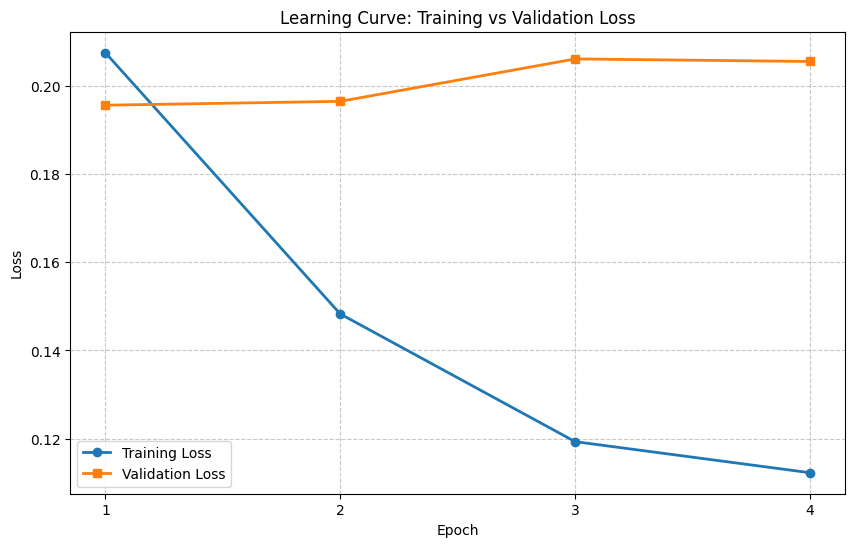

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(range(1, len(history["train_loss"]) + 1), history["train_loss"],
         label="Training Loss", marker='o', linewidth=2)

# Plot Validation Loss
plt.plot(range(1, len(history["val_loss"]) + 1), history["val_loss"],
         label="Validation Loss", marker='s', linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve: Training vs Validation Loss")
plt.xticks(range(1, len(history["train_loss"]) + 1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

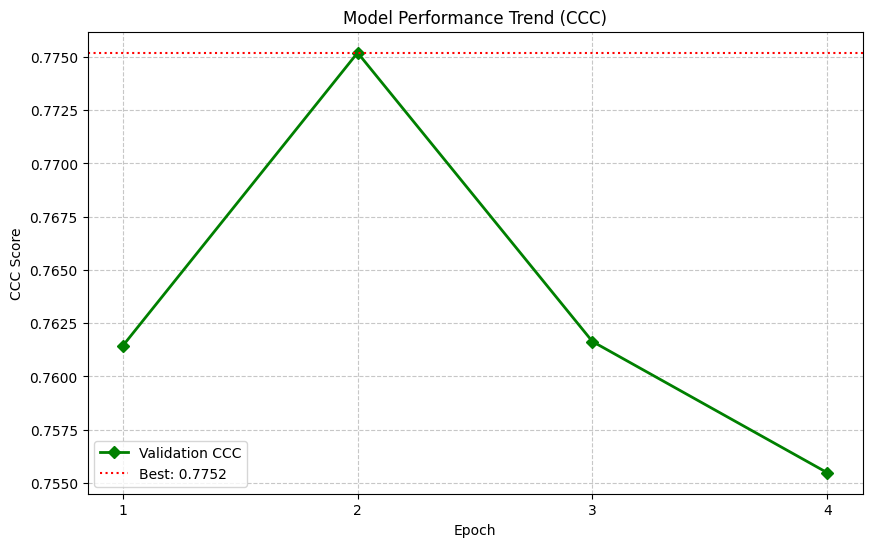

In [69]:
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(history["val_ccc_final_score"]) + 1),
         history["val_ccc_final_score"],
         color='green', marker='D', linewidth=2, label="Validation CCC")

plt.xlabel("Epoch")
plt.ylabel("CCC Score")
plt.title("Model Performance Trend (CCC)")
plt.xticks(range(1, len(history["val_ccc_final_score"]) + 1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight the best score
best_score = max(history["val_ccc_final_score"])
plt.axhline(y=best_score, color='red', linestyle=':', label=f"Best: {best_score:.4f}")
plt.legend()

plt.show()

In [70]:
def evaluate_model(model, dataloader, device,
                   v_mean=0, v_std=1, a_mean=0, a_std=1,
                   normalize=False, use_amp=False, verbose=True):
    """
    Comprehensive model evaluation with proper denormalization

    Args:
        model: Trained model
        dataloader: DataLoader for evaluation
        device: Device to evaluate on
        v_mean, v_std: Valence normalization stats
        a_mean, a_std: Arousal normalization stats
        normalize: Whether to denormalize predictions
        use_amp: Use automatic mixed precision
        verbose: Print progress bar

    Returns:
        Dictionary with all evaluation metrics
    """
    model.eval()

    preds_list = []
    labels_list = []

    iterator = tqdm(dataloader, desc="Evaluating") if verbose else dataloader

    with torch.no_grad():
        for batch in iterator:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]  # Keep on CPU initially

            # Forward pass
            if use_amp and device == "cuda":
                with torch.cuda.amp.autocast():
                    outputs = model(input_ids, attention_mask)
            else:
                outputs = model(input_ids, attention_mask)

            # Move to CPU and convert to numpy
            outputs_np = outputs.cpu().numpy()
            labels_np = labels.cpu().numpy()

            # Denormalize if needed
            if normalize:
                outputs_np[:, 0] = outputs_np[:, 0] * v_std + v_mean
                outputs_np[:, 1] = outputs_np[:, 1] * a_std + a_mean
                labels_np[:, 0] = labels_np[:, 0] * v_std + v_mean
                labels_np[:, 1] = labels_np[:, 1] * a_std + a_mean

            preds_list.append(outputs_np)
            labels_list.append(labels_np)

    # Stack all predictions and labels
    preds = np.vstack(preds_list)
    labels = np.vstack(labels_list)

    # ========== Compute Metrics ==========

    # Overall metrics
    mae = np.mean(np.abs(preds - labels))
    mse = np.mean((preds - labels) ** 2)
    rmse = np.sqrt(mse)

    # Valence metrics
    mae_v = mean_absolute_error(labels[:, 0], preds[:, 0])
    mse_v = mean_squared_error(labels[:, 0], preds[:, 0])
    rmse_v = np.sqrt(mse_v)
    pcc_v, _ = pearsonr(preds[:, 0], labels[:, 0])
    ccc_v = concordance_ccc(preds[:, 0], labels[:, 0])
    r2_v = r2_score(labels[:, 0], preds[:, 0])

    # Arousal metrics
    mae_a = mean_absolute_error(labels[:, 1], preds[:, 1])
    mse_a = mean_squared_error(labels[:, 1], preds[:, 1])
    rmse_a = np.sqrt(mse_a)
    pcc_a, _ = pearsonr(preds[:, 1], labels[:, 1])
    ccc_a = concordance_ccc(preds[:, 1], labels[:, 1])
    r2_a = r2_score(labels[:, 1], preds[:, 1])

    # Aggregate scores
    ccc_final_score = (ccc_v + ccc_a) / 2
    pcc_avg = (pcc_v + pcc_a) / 2
    rmse_avg = (rmse_v + rmse_a) / 2
    mae_avg = (mae_v + mae_a) / 2

    # Return comprehensive metrics
    metrics = {
        # Overall
        "MAE": float(mae),
        "MSE": float(mse),
        "RMSE": float(rmse),

        # Valence
        "MAE_V": float(mae_v),
        "MSE_V": float(mse_v),
        "RMSE_V": float(rmse_v),
        "PCC_V": float(pcc_v),
        "CCC_V": float(ccc_v),
        "R2_V": float(r2_v),

        # Arousal
        "MAE_A": float(mae_a),
        "MSE_A": float(mse_a),
        "RMSE_A": float(rmse_a),
        "PCC_A": float(pcc_a),
        "CCC_A": float(ccc_a),
        "R2_A": float(r2_a),

        # Aggregates
        "MAE_AVG": float(mae_avg),
        "RMSE_AVG": float(rmse_avg),
        "PCC_AVG": float(pcc_avg),
        "CCC_FINAL": float(ccc_final_score)
    }

    return metrics


def print_evaluation_results(metrics, model_name="Model"):
    """Pretty print evaluation results"""
    print(f"\n{'='*80}")
    print(f"{model_name} - Evaluation Results")
    print(f"{'='*80}\n")

    print("📊 Overall Metrics:")
    print(f"   MAE:  {metrics['MAE']:.4f}")
    print(f"   RMSE: {metrics['RMSE']:.4f}")

    print("\n📈 Valence Metrics:")
    print(f"   MAE:  {metrics['MAE_V']:.4f} | RMSE: {metrics['RMSE_V']:.4f}")
    print(f"   PCC:  {metrics['PCC_V']:.4f} | CCC:  {metrics['CCC_V']:.4f}")
    print(f"   R²:   {metrics['R2_V']:.4f}")

    print("\n📉 Arousal Metrics:")
    print(f"   MAE:  {metrics['MAE_A']:.4f} | RMSE: {metrics['RMSE_A']:.4f}")
    print(f"   PCC:  {metrics['PCC_A']:.4f} | CCC:  {metrics['CCC_A']:.4f}")
    print(f"   R²:   {metrics['R2_A']:.4f}")

    print("\n🎯 Final Scores:")
    print(f"   CCC Final Score: {metrics['CCC_FINAL']:.4f}")
    print(f"   Avg RMSE:        {metrics['RMSE_AVG']:.4f}")
    print(f"   Avg PCC:         {metrics['PCC_AVG']:.4f}")

    print(f"\n{'='*80}\n")
#print_evaluation_results(eval_metrics, model_name=model_name)

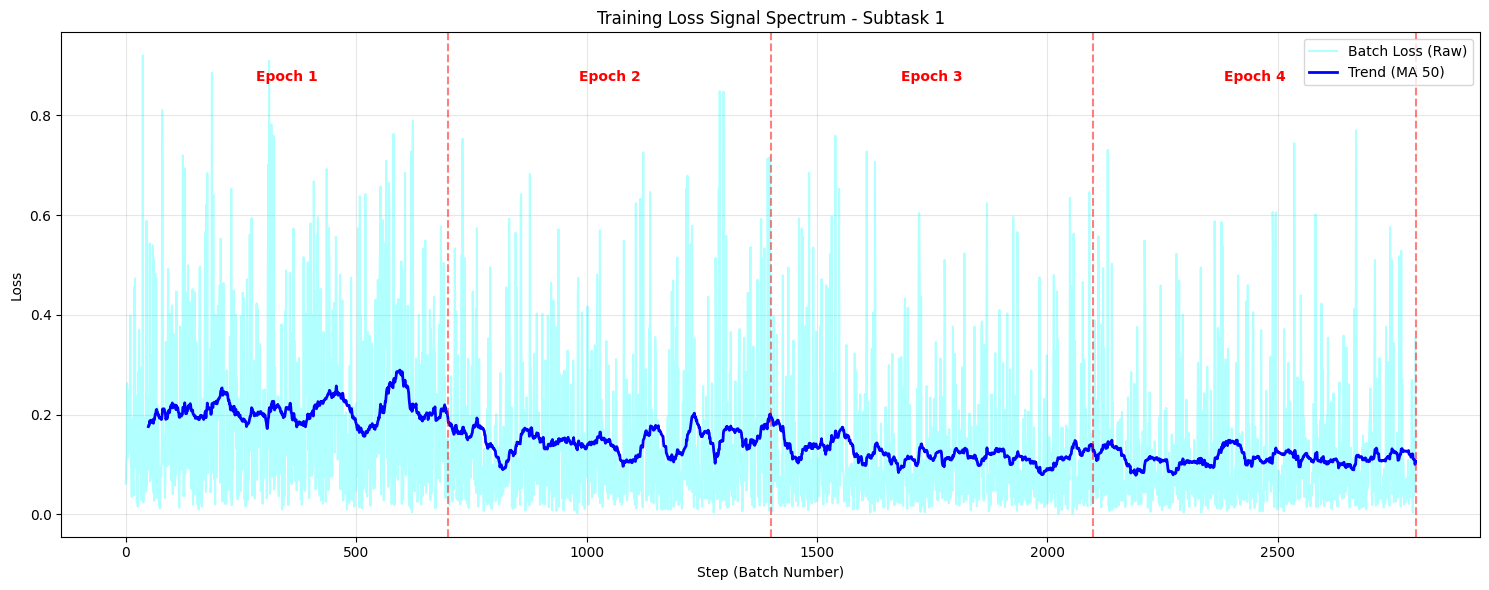

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(a, n=30):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.figure(figsize=(15, 6))

# 1. Plot the raw "Spectrum" (The noise)
plt.plot(all_batch_losses, label="Batch Loss (Raw)", alpha=0.3, color='cyan')

# 2. Plot the "Signal" (The smoothed trend)
window = 50
if len(all_batch_losses) > window:
    smoothed = moving_average(all_batch_losses, n=window)
    plt.plot(range(window-1, len(all_batch_losses)), smoothed,
             label=f"Trend (MA {window})", color='blue', linewidth=2)

# 3. Add Epoch Markers
batches_per_epoch = 700 # Based on your previous logs
for i in range(1, EPOCHS + 1):
    plt.axvline(x=i * batches_per_epoch, color='red', linestyle='--', alpha=0.5)
    plt.text(i * batches_per_epoch - (batches_per_epoch/2), plt.ylim()[1]*0.9,
             f"Epoch {i}", color='red', weight='bold', ha='center')

plt.title("Training Loss Signal Spectrum - Subtask 1")
plt.xlabel("Step (Batch Number)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [72]:
import pandas as pd
import json
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer

# 1. RE-DEFINE MISSING VARIABLES (If not in memory)
# Use the same model name you used during training
tokenizer = AutoTokenizer.from_pretrained(model_name)
NORMALIZE = True # Based on your training code

# 2. PREPARE DEV DATAFRAME
# Convert your dev_data list to a DataFrame
dev_df = pd.DataFrame(dev_data)

# Add dummy labels to prevent KeyError during evaluation/dataset loading
dev_df['valence'] = 0.0
dev_df['arousal'] = 0.0

# Ensure 'Text' exists (Dataset class often looks for capitalized 'Text')
if 'text' in dev_df.columns:
    dev_df['Text'] = dev_df['text']

# 3. CREATE DEV LOADER (For evaluate_model function)
dev_dataset = VARegressionDataset(
    df=dev_df,
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    v_stats=(v_mean, v_std),
    a_stats=(a_mean, a_std),
    normalize=NORMALIZE
)

dev_loader = DataLoader(
    dev_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# ========== LOAD BEST MODEL ==========
print("Loading best model...")
checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Sync stats from checkpoint
norm_stats = checkpoint['normalization']
v_mean, v_std = norm_stats['v_mean'], norm_stats['v_std']
a_mean, a_std = norm_stats['a_mean'], norm_stats['a_std']
normalize = norm_stats['normalize']
MAX_LEN = checkpoint['config']['max_len']

# ========== BATCH PREDICTION ==========
print("\n🚀 Starting Batch Prediction...")

# Find the correct text column (handles 'text', 'Text', 'TEXT', etc.)
text_col = next((c for c in dev_df.columns if c.lower() == 'text'), None)

if text_col is None:
    print(f"❌ Error: Could not find a text column. Available columns: {list(dev_df.columns)}")
    # Manual fallback if you see the column name in the error message
    # all_texts = dev_df["ActualColumnName"].tolist()
else:
    print(f"Found text column: '{text_col}'")
    all_texts = dev_df[text_col].tolist()

    predictions = predict_va_batch(
        texts=all_texts,
        model=model,
        tokenizer=tokenizer,
        device=device,
        max_len=MAX_LEN,
        v_mean=v_mean,
        v_std=v_std,
        a_mean=a_mean,
        a_std=a_std,
        normalize=normalize,
        batch_size=32,
        use_amp=USE_AMP
    )
    print("✅ Prediction complete.")

# ========== GENERATE SUBMISSION (Handling shared VA values) ==========
submission_dict = {}

# Use the column names we identified earlier
id_col = next((c for c in dev_df.columns if c.lower() == 'id'), 'ID')
aspect_col = next((c for c in dev_df.columns if c.lower() == 'aspect'), 'Aspect')

for i, row in dev_df.iterrows():
    idx = row[id_col]
    aspect_val = row[aspect_col]
    v, a = predictions[i]  # Global sentence prediction

    if idx not in submission_dict:
        submission_dict[idx] = []

    # If the aspect is a list, split it into separate objects
    if isinstance(aspect_val, list):
        for single_aspect in aspect_val:
            submission_dict[idx].append({
                "Aspect": str(single_aspect),
                "VA": f"{v:.2f}#{a:.2f}" # Both get the same predicted VA
            })
    else:
        # If it's a string, just one object
        submission_dict[idx].append({
            "Aspect": str(aspect_val),
            "VA": f"{v:.2f}#{a:.2f}"
        })

# Final assembly
final_submission = [{"ID": k, "Aspect_VA": v} for k, v in submission_dict.items()]

# Save to file
with open("submission.jsonl", "w") as f:
    for item in final_submission:
        f.write(json.dumps(item) + "\n")

print("✅ Submission file generated with one object per aspect.")

Loading best model...

🚀 Starting Batch Prediction...
Found text column: 'Text'
✅ Prediction complete.
✅ Submission file generated with one object per aspect.


In [ ]:
num_epochs_ran = len(history_df["train_loss"])
epoch = [i for i in range(1, num_epochs_ran +1)]

In [ ]:
!ls


In [ ]:
!git clone git@github.com:SolomonM-Kebede/Transformation-based-NLP.git
%cd Transformation-based-NLP

!git add DimABSA_TaskA.ipynb
!git commit -m "Update notebook"
!git push